# Pipelines, RandomizedSearch, and Transformers

##### Author: Alex Sherman | alsherman@deloitte.com

##### Agenda:
1. Pipelines
2. Advanced Cross Validation (randomized Hyperparameter tuning)
3. Feature Union (combining pipelines)
4. Custom Transformers (customizing pipeline components)

In [30]:
import string
from collections import defaultdict
import pandas as pd
import numpy as np
from configparser import ConfigParser, ExtendedInterpolation

# NLP
import spacy
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
from spacy.lang.en.stop_words import STOP_WORDS

# feature engineering (vectorization and dimensionality reduction)
from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder, LabelBinarizer, FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB

# machine learning experiment set-up
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile

# evaluation metrics
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn import datasets

# visualization
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')

REPORTER_DATA_PATH = config['DATA']['REPORTER_DATA_PATH']

### Set up a classification problem

In [112]:
df = pd.read_csv(
      REPORTER_DATA_PATH
    , encoding='latin-1'
    , error_bad_lines=False
    , nrows=1000
    , usecols=['ADMINISTERING_IC', 'FY',  'IC_NAME', 'PROJECT_TITLE']
)

df.head()

,ACTIVITY,ADMINISTERING_IC,FY,IC_NAME,PROJECT_TITLE
0,N01,HL,2009,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",National Oral Health Information Center
1,C06,RR,2009,NATIONAL CENTER FOR RESEARCH RESOURCES,The Center for Oral/Head &Neck Oncology Research
2,C06,RR,2009,NATIONAL CENTER FOR RESEARCH RESOURCES,Extramural Research Facilities Construction Constructio*
3,C06,RR,2009,NATIONAL CENTER FOR RESEARCH RESOURCES,Cardiovascular Injury and Repair Research Facility
4,C06,RR,2009,NATIONAL CENTER FOR RESEARCH RESOURCES,PAR04-122 Satellite Animal Facility Construction Project


In [113]:
# set up a binary classification problem
df['NIAID'] = (df.IC_NAME == 'NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASES')
df.head()

,ACTIVITY,ADMINISTERING_IC,FY,IC_NAME,PROJECT_TITLE,NIAID
0,N01,HL,2009,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",National Oral Health Information Center,False
1,C06,RR,2009,NATIONAL CENTER FOR RESEARCH RESOURCES,The Center for Oral/Head &Neck Oncology Research,False
2,C06,RR,2009,NATIONAL CENTER FOR RESEARCH RESOURCES,Extramural Research Facilities Construction Constructio*,False
3,C06,RR,2009,NATIONAL CENTER FOR RESEARCH RESOURCES,Cardiovascular Injury and Repair Research Facility,False
4,C06,RR,2009,NATIONAL CENTER FOR RESEARCH RESOURCES,PAR04-122 Satellite Animal Facility Construction Project,False


In [114]:
# check the row count
df.shape

(1000, 6)

In [115]:
# use the section names to determine if the section text will contain the term fee
X = df['PROJECT_TITLE']
y = df['NIAID']

##### Example ML Process

In [116]:
%%time

# set up ML experiment
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# tfidf transform data
tfidf = TfidfVectorizer()
fit_vect = tfidf.fit_transform(X_train)

# lsi transform data
lsi = TruncatedSVD(n_components=100, random_state=42)
fit_lsi = lsi.fit_transform(fit_vect)

# build random forest
rf = RandomForestClassifier(random_state=42)
rf.fit(fit_lsi, y_train)

# make predictions
test_vect = tfidf.transform(X_test)
test_lsi = lsi.transform(test_vect)
y_pred = rf.predict(test_lsi)

# evaluate prediction
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.85      0.98      0.91       208
       True       0.60      0.14      0.23        42

avg / total       0.81      0.84      0.80       250

Wall time: 208 ms


### Example INCORRECT(!!!) cross validation

In the below process, we transform the data with tfidf and lsi before passing it to the RandomizedSearchCV

Problems:
1. All the data is passed to tfidf, so it learns the full vocabulary, instead of the vocabulary from only the training data
2. All the data is passed to lsi, so it learns the full data, instead of the from only the training data
3. We are only tuning the model hyperparameters instead of all transformer and feature selection hyperparameters

In [54]:
%%time

from sklearn.model_selection import RandomizedSearchCV

# tfidf transform data
tfidf = TfidfVectorizer()
fit_vect = tfidf.fit_transform(X)  # wrong! - using all data 

# lsi transform data
lsi = TruncatedSVD(random_state=42)
fit_lsi = lsi.fit_transform(fit_vect)  # wrong! - using all data

# hyperparameters to test
param_dist = {'n_estimators':range(10,500,5)}  # limited to model hyperparameters

# set cross validatation to test n random hyperparameters
grid = RandomizedSearchCV(
      RandomForestClassifier(random_state=42)
    , param_distributions=param_dist
    , n_iter=5
    , cv=3
    , refit='accuracy'
    , scoring='accuracy'
    , return_train_score=True
)
grid.fit(fit_lsi,y)

# review results
results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)

Wall time: 6.9 s


In [55]:
results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.545347,0.034346,0.783,1.0,435,{'n_estimators': 435},1,0.778443,1.0,0.780781,1.0,0.789790,1.0,0.032715,0.000489,0.004892,0.0
3,0.461356,0.032657,0.783,1.0,380,{'n_estimators': 380},1,0.781437,1.0,0.783784,1.0,0.783784,1.0,0.016092,0.002054,0.001107,0.0
2,0.526667,0.035334,0.781,1.0,415,{'n_estimators': 415},3,0.778443,1.0,0.780781,1.0,0.783784,1.0,0.023272,0.002626,0.002186,0.0
1,0.092663,0.007001,0.780,1.0,70,{'n_estimators': 70},4,0.772455,1.0,0.780781,1.0,0.786787,1.0,0.006309,0.002159,0.005878,0.0
4,0.112645,0.008679,0.780,1.0,95,{'n_estimators': 95},4,0.769461,1.0,0.786787,1.0,0.783784,1.0,0.003790,0.000937,0.007563,0.0


### Pipeline

Pipeline of transforms with a final estimator.

Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. The transformers in the pipeline can be cached using memory argument.

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a double underscore ‘__’. A step’s estimator may be replaced entirely by setting the parameter with its name to another estimator, or a transformer removed by setting to None.

### Pipelines in sklearn


Pipelines chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. 

Pipelines Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. The transformers in the pipeline can be cached using memory argument.

Pipeline serves serveral purposes:

- **Convenience and encapsulation**: You only have to call fit and predict once on your data to fit a whole sequence of estimators.

- **Joint parameter selection**: You can grid search over parameters of all estimators in the pipeline at once.

- **Safety**: Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.
All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.)

SOURCE:
- [Pipeline: chaining estimators](http://scikit-learn.org/stable/modules/pipeline.html#pipeline)

In [56]:
from sklearn.pipeline import Pipeline

# define a pipeline
# the pipeline includes a list of steps to complete
# each step is a tuple with a name for the step and an uninstantiated class 
pipe = Pipeline([
      ('tfidf', TfidfVectorizer(stop_words='english'))
    , ('lsi', TruncatedSVD(random_state=42))
    , ('clf', LogisticRegression(class_weight='balanced', random_state=42))
])

# fitting a pipeline is the same as calling fit on every intermediate steps
pipe.fit(X_train,y_train)

# predict using the model at the end of the pipeline
y_pred = pipe.predict(X_test)

In [57]:
# evaluate prediction
print(classification_report(y_test, y_pred))
print('accuracy: {}'.format(accuracy_score(y_test, y_pred)))

             precision    recall  f1-score   support

      False       0.82      0.63      0.71       208
       True       0.15      0.33      0.21        42

avg / total       0.71      0.58      0.63       250

accuracy: 0.58


##### view the results of the model on the testing datast

In [71]:
# optional - expand the column width to see more text
pd.set_option('max_colwidth', 60)

# combine X_test/y_test and add the prediction as a new column
# to review model predictions
df_test = pd.concat([X_test, y_test], axis=1) 
df_test['pred'] = y_pred  

# define the quadrants of a confusion matrix
fp = (df_test.NIAID == False) & (df_test.pred == True)
fn = (df_test.NIAID == True) & (df_test.pred == False)
tp = (df_test.NIAID == True) & (df_test.pred == True)
tn = (df_test.NIAID == False) & (df_test.pred == False)

confusion_matrix = [
      ('FALSE POSITIVES',fp)
    , ('FALSE NEGATIVES',fn)
    , ('TRUE POSITIVES',tp)
    , ('TRUE NEGATIVES',tn)
]

# view examples of each type of result in the confusion matrix
# use this to help determine new useful feautes to improve the model
for key, val in confusion_matrix:
    print('Result Type: {}'.format(key))
    print(df_test[val][['PROJECT_TITLE','NIAID','pred']][0:5], '\n\n')

Result Type: FALSE POSITIVES
                                                   PROJECT_TITLE  NIAID  pred
521                              Role of TrpmI3 in Sensory Cells  False  True
660  Role of Allopregnanolone in Mediating the Adverse Effect...  False  True
411  The role of Sphingosine Kinase 1 in a Mouse Model of Chr...  False  True
859  Effects of age-related cognitvie decline on attitudes to...  False  True
76   Generation of tumor stem cell lines for directed therape...  False  True 


Result Type: FALSE NEGATIVES
                                                   PROJECT_TITLE  NIAID   pred
973  Investigation of a novel clonal variation pathway in Xen...   True  False
938  The structure, dynamics and function of the pore-forming...   True  False
371  Targeting Trypanosoma brucei S-adenosylmethionine decarb...   True  False
947  Discovery of Small Molecules that Restore Methicillin Se...   True  False
346  Molecular and Cellular Biology of an Ancient Allorecogni...   True  Fal

### Analyze pipeline components

In [72]:
# view the entire pipeline
pipe

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...alty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [73]:
# view a dict of each step in the pipeline
# this is useful to select a single fit transformer or estimator
pipe.named_steps

{'clf': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'lsi': TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
        random_state=42, tol=0.0),
 'tfidf': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
         stop_words='english', strip_accents=None, sublinear_tf=False,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None)}

In [74]:
# select only the tfidfvectorizer
pipe.named_steps['tfidf']

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [75]:
print(dir(pipe.named_steps['tfidf']))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_char_ngrams', '_char_wb_ngrams', '_check_vocabulary', '_count_vocab', '_get_param_names', '_limit_features', '_sort_features', '_tfidf', '_validate_vocabulary', '_white_spaces', '_word_ngrams', 'analyzer', 'binary', 'build_analyzer', 'build_preprocessor', 'build_tokenizer', 'decode', 'decode_error', 'dtype', 'encoding', 'fit', 'fit_transform', 'fixed_vocabulary_', 'get_feature_names', 'get_params', 'get_stop_words', 'idf_', 'input', 'inverse_transform', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'set_params', 'smooth_idf', 'stop_words', 'stop_words_', 'strip_accents', 'sublinear_tf', 'token

In [76]:
# extract the features names from the fit tfidf in the pipeline
feature_names = pipe.named_steps['tfidf'].get_feature_names()

# print some features names learned by tfidf
# ignore the first few hundred which are primarily numbers
print(feature_names[300:400])

['cardiac', 'care', 'caregiver', 'caregivers', 'carotid', 'cartilage', 'cascades', 'cashew', 'castration', 'catalysis', 'catalysts', 'catalytic', 'catalyzed', 'categorical', 'cation', 'cationic', 'caulobacter', 'causes', 'caveolin', 'cbt', 'cd', 'cd148', 'cd4', 'cd40', 'cd44', 'cd45', 'cd8', 'cdh1', 'celastrol', 'cell', 'cells', 'cellular', 'center', 'centered', 'central', 'cerebellar', 'cerebral', 'cervical', 'cessation', 'cf', 'cf3', 'cfs', 'cftr', 'challenge', 'changes', 'channel', 'channelopathies', 'channels', 'chaperone', 'chaperones', 'characterization', 'characterizing', 'charmm', 'cheating', 'chemical', 'chemistry', 'chemokines', 'chemoprevention', 'chemorepellent', 'chemotaxis', 'chemotherapeutic', 'chemotherapy', 'child', 'childhood', 'children', 'china', 'chk2', 'chlamydial', 'chloride', 'cholerae', 'cholesterol', 'cholinergic', 'chondroitin', 'chromans', 'chromatin', 'chronic', 'church', 'cigarette', 'ciliary', 'circadian', 'circuit', 'circuitry', 'circuits', 'circulating'

In [77]:
print(dir(pipe.named_steps['lsi']))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_param_names', 'algorithm', 'components_', 'explained_variance_', 'explained_variance_ratio_', 'fit', 'fit_transform', 'get_params', 'inverse_transform', 'n_components', 'n_iter', 'random_state', 'set_params', 'singular_values_', 'tol', 'transform']


In [78]:
# extract the variance ratio from the truncatedSVD (latent semantic indexing)
pipe.named_steps['lsi'].n_components

2

In [79]:
print(dir(pipe.named_steps['clf']))

['C', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_estimator_type', '_get_param_names', '_predict_proba_lr', 'class_weight', 'classes_', 'coef_', 'decision_function', 'densify', 'dual', 'fit', 'fit_intercept', 'get_params', 'intercept_', 'intercept_scaling', 'max_iter', 'multi_class', 'n_iter_', 'n_jobs', 'penalty', 'predict', 'predict_log_proba', 'predict_proba', 'random_state', 'score', 'set_params', 'solver', 'sparsify', 'tol', 'verbose', 'warm_start']


In [80]:
pipe.named_steps['clf'].coef_

array([[2.57508478, 0.06905342]])

### Cross Validation with pipelines

### Hyperparameter tuning

Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.

It is possible and recommended to search the hyper-parameter space for the best cross validation score.

Two generic approaches to sampling search candidates are provided in scikit-learn: for given values, GridSearchCV exhaustively considers all parameter combinations, while RandomizedSearchCV can sample a given number of candidates from a parameter space with a specified distribution. After describing these tools we detail best practice applicable to both approaches.

Note that it is common that a small subset of those parameters can have a large impact on the predictive or computation performance of the model while others can be left to their default values. It is recommended to read the docstring of the estimator class to get a finer understanding of their expected behavior, possibly by reading the enclosed reference to the literature.


##### RandomizedSearchCV
While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

A budget can be chosen independent of the number of parameters and possible values.
Adding parameters that do not influence the performance does not decrease efficiency.
Specifying how parameters should be sampled is done using a dictionary, very similar to specifying parameters for GridSearchCV. Additionally, a computation budget, being the number of sampled candidates or sampling iterations, is specified using the n_iter parameter. For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified

SOURCE:
- [Tuning the hyper-parameters of an estimator](http://scikit-learn.org/stable/modules/grid_search.html#grid-search-tips)
- [Publication - Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)


In [81]:
# review the pipeline
pipe = Pipeline([
      ('tfidf', TfidfVectorizer())
    , ('lsi', TruncatedSVD(random_state=42))
    , ('clf', LogisticRegression(class_weight='balanced', random_state=42))
])

In [82]:
# set a parameter distribution which lists all the possible 
# hyperparameters to test

param_dist = {
       #  tfidf hyperparams
         'tfidf__max_features': range(200,1000,10)
       , 'tfidf__stop_words': [None, 'english']
       , 'tfidf__ngram_range': [(1,1),(1,2), (1,3)]
 
       #   lsi hyperparams
       ,  'lsi__n_components': range(10,150)
      
       #   logistic regression hyperparams
       ,  'clf__penalty':['l1','l2']
       ,  'clf__C':np.linspace(1e3, 10, 100)
}

In [84]:
from sklearn.model_selection import RandomizedSearchCV

# set cross validatation to test n random hyperparameters
grid = RandomizedSearchCV(
      pipe
    , param_distributions=param_dist
    , n_iter=5
    , cv=3
    , refit='f1'
    , scoring='f1'
    , return_train_score=True
)

grid.fit(X,y)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...alty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'clf__C': array([1000.,  990., ...,   20.,   10.]), 'tfidf__max_features': range(200, 1000, 10), 'lsi__n_components': range(10, 150), 'clf__penalty': ['l1', 'l2'], 'tfidf__stop_words': [None, 'english'], 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
          pre_dispatch='2*n_jobs', random_state=None, refit='f1',
          return_train_score=True, scoring='f1', verbose=0)

In [85]:
pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__C,param_clf__penalty,param_lsi__n_components,param_tfidf__max_features,param_tfidf__ngram_range,param_tfidf__stop_words,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.400662,0.010668,0.479222,0.790711,730,l1,118,910,"(1, 2)",None,...,0.396947,0.861314,0.558824,0.755853,0.482143,0.754967,0.143133,0.002867,0.066135,0.049925
1,0.055347,0.004996,0.478635,0.667007,940,l2,84,880,"(1, 1)",None,...,0.375000,0.712871,0.565217,0.660317,0.496000,0.627832,0.002474,0.001410,0.078638,0.035038
3,0.158996,0.004011,0.468473,0.722292,450,l1,98,310,"(1, 1)",english,...,0.445860,0.761905,0.463277,0.694006,0.496350,0.710963,0.105567,0.000015,0.020942,0.028854
2,0.141333,0.011668,0.467485,0.766984,790,l2,116,980,"(1, 3)",None,...,0.450331,0.800000,0.500000,0.745098,0.452174,0.755853,0.015326,0.002358,0.022987,0.023755
4,0.137333,0.007333,0.464810,0.692299,200,l1,93,280,"(1, 2)",None,...,0.433121,0.737201,0.471338,0.664615,0.490066,0.675079,0.028939,0.001885,0.023707,0.032037


In [86]:
# set several evaluation metrics to collect during RandomizedSearch
scoring = ['accuracy','neg_log_loss','precision','recall','f1']

grid = RandomizedSearchCV(
      pipe
    , param_distributions=param_dist
    , n_iter=5
    , cv=3
    , refit='f1'
    , scoring=scoring  # track multiple evaluation metrics
    , return_train_score=True
)

grid.fit(X,y)
pd.DataFrame(grid.cv_results_)

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_f1,mean_test_neg_log_loss,mean_test_precision,mean_test_recall,mean_train_accuracy,mean_train_f1,mean_train_neg_log_loss,...,std_test_accuracy,std_test_f1,std_test_neg_log_loss,std_test_precision,std_test_recall,std_train_accuracy,std_train_f1,std_train_neg_log_loss,std_train_precision,std_train_recall
0,1.630679,0.034325,0.738,0.443060,-1.038265,0.356108,0.595562,0.899510,0.772261,-0.262011,...,0.008908,0.045071,0.321118,0.019105,0.117891,0.014789,0.025530,0.048365,0.036539,0.014237
1,0.787655,0.031680,0.797,0.481412,-1.316375,0.444448,0.528298,0.929020,0.836580,-0.225716,...,0.018376,0.028970,0.937828,0.039830,0.038005,0.028982,0.060335,0.058037,0.090203,0.006861
2,0.137655,0.049335,0.789,0.478477,-0.840449,0.427495,0.544843,0.933514,0.843475,-0.189698,...,0.019775,0.048953,0.192531,0.042043,0.064134,0.023278,0.047787,0.059772,0.066984,0.010481
3,0.033000,0.039333,0.679,0.417790,-0.644114,0.315703,0.640250,0.754501,0.521654,-0.495129,...,0.061380,0.028820,0.113245,0.039177,0.081966,0.021482,0.031423,0.023696,0.028768,0.031248
4,1.071001,0.022335,0.797,0.459247,-2.257947,0.441006,0.489021,0.953021,0.886897,-0.143777,...,0.017156,0.040131,1.421211,0.039331,0.085690,0.030040,0.071121,0.088789,0.115403,0.010481


### Add distributions for RandomizedGridSearch hyperparameters sampling

##### scipy.stats.distributions

[e.g. scipy.stats.lognorm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html#scipy.stats.lognorm)

In [87]:
from scipy.stats import lognorm
dist = np.linspace(lognorm.ppf(0.01, 1), lognorm.ppf(0.99, 1), 1000)

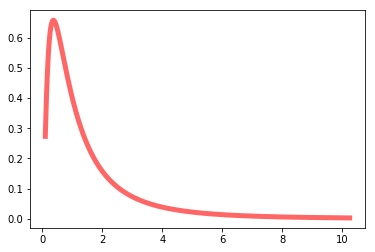

In [88]:
fig, ax = plt.subplots(1, 1)
ax.plot(dist, lognorm.pdf(dist, 1), 'r-', lw=5, alpha=0.6, label='lognorm pdf')

In [89]:
# scipy.stats.lognorm
param_dist = {'clf__C':dist}

grid = RandomizedSearchCV(
      pipe
    , param_distributions=param_dist
    , n_iter=10
    , cv=2
    , scoring='f1'
    , return_train_score=True
)

grid.fit(X,y)

# selected eval columns
eval_cols = ['mean_test_score','param_clf__C']
pd.DataFrame(grid.cv_results_)[eval_cols]

,mean_test_score,param_clf__C
0,0.250306,7.21489
1,0.249905,7.29611
2,0.249905,7.47886
3,0.248288,5.73255
4,0.238826,0.422547
5,0.242138,0.209334
6,0.248288,6.35188
7,0.246438,2.25008
8,0.243840,1.49876
9,0.250306,7.14382


##### RandomizedGridSearch Robustness to failure with error_score

Some parameter settings may result in a failure to fit one or more folds of the data. By default, this will cause the entire search to fail, even if some parameter settings could be fully evaluated. 

**Setting error_score=0** (or =np.NaN) will make the procedure robust to such failure, issuing a warning and setting the score for that fold to 0 (or NaN), but completing the search.

NOTE: Without setting this parameter a single hyperparameter mismatch could cause an entire training routine to fail. For example, if you set a range of max_features with the lowest value having a lower option than another hyperparameter such as lsi or pca components. 

Speaking from personal experience, I have had 8-hour training routines fail in the last hour due to this issue.

In [90]:
pipe = Pipeline([
      ('tfidf', TfidfVectorizer())
    , ('lsi', TruncatedSVD(random_state=42))
    , ('clf', LogisticRegression(class_weight='balanced', random_state=42))
])

# set a parameter distribution which lists all the possible hyperparameters to test
param_dist = {
       #  tfidf hyperparams
         'tfidf__max_features': [100,120]
       #   lsi hyperparams
       ,  'lsi__n_components': [110, 120]
}

grid = RandomizedSearchCV(
      pipe
    , param_distributions=param_dist
    , n_iter=4
    , cv=2
    , scoring='f1'
    , return_train_score=True
    , error_score=0
)

grid.fit(X,y)
pd.DataFrame(grid.cv_results_)

C:\Users\alsherman\AppData\Local\Continuum\anaconda3\envs\guild\lib\site-packages\sklearn\model_selection\_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError('n_components must be < n_features; got 110 >= 100',)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
C:\Users\alsherman\AppData\Local\Continuum\anaconda3\envs\guild\lib\site-packages\sklearn\model_selection\_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError('n_components must be < n_features; got 110 >= 100',)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
C:\Users\alsherman\AppData\Local\Continuum\anaconda3\envs\guild\lib\site-packages\sklearn\model_selection\_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_lsi__n_components,param_tfidf__max_features,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.011001,0.000,0.000000,0.000000,110,100,"{'tfidf__max_features': 100, 'lsi__n_components': 110}",2,0.000000,0.000000,0.000000,0.000000,0.000999,0.000000e+00,0.000000,0.000000
1,0.040997,0.006,0.389897,0.666175,110,120,"{'tfidf__max_features': 120, 'lsi__n_components': 110}",1,0.376569,0.693694,0.403226,0.638655,0.003005,7.152557e-07,0.013328,0.027519
2,0.012000,0.000,0.000000,0.000000,120,100,"{'tfidf__max_features': 100, 'lsi__n_components': 120}",2,0.000000,0.000000,0.000000,0.000000,0.001993,0.000000e+00,0.000000,0.000000
3,0.016002,0.000,0.000000,0.000000,120,120,"{'tfidf__max_features': 120, 'lsi__n_components': 120}",2,0.000000,0.000000,0.000000,0.000000,0.000997,0.000000e+00,0.000000,0.000000


### Nested cross-validation (CV)

Nested cross-validation (CV) is often used to train a model in which hyperparameters also need to be optimized. Nested CV estimates the generalization error of the underlying model and its (hyper)parameter search. Choosing the parameters that maximize non-nested CV biases the model to the dataset, yielding an overly-optimistic score.

Model selection without nested CV uses the same data to tune model parameters and evaluate model performance. Information may thus “leak” into the model and overfit the data. The magnitude of this effect is primarily dependent on the size of the dataset and the stability of the model.

To avoid this problem, nested CV effectively uses a series of train/validation/test set splits. In the inner loop (here executed by GridSearchCV), the score is approximately maximized by fitting a model to each training set, and then directly maximized in selecting (hyper)parameters over the validation set. In the outer loop (here in cross_val_score), generalization error is estimated by averaging test set scores over several dataset splits.

SOURCE:
- [Nested versus non-nested cross validation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py)
- [Nested Cross Validation: When Cross Validation Isn’t Enough](https://www.elderresearch.com/blog/nested-cross-validation)
- [Nested Cross Validation - sklearn](https://chrisalbon.com/machine_learning/model_evaluation/nested_cross_validation/)

In [91]:
from sklearn.model_selection import cross_val_score

param_dist = {
    'tfidf__max_features': [150]
  , 'lsi__n_components': [110, 120, 130]
}

grid = RandomizedSearchCV(
      pipe
    , param_distributions=param_dist
    , n_iter=3
    , cv=2
    , scoring='f1'
    , return_train_score=True
)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid, X=X, y=y, cv=3)
nested_score.mean()

0.44511100394044806

### Feature Union

FeatureUnion combines several transformer objects into a new transformer that combines their output. A FeatureUnion takes a list of transformer objects. During fitting, each of these is fit to the data independently. For transforming data, the transformers are applied in parallel, and the sample vectors they output are concatenated end-to-end into larger vectors.

FeatureUnion serves the same purposes as Pipeline - convenience and joint parameter estimation and validation.

FeatureUnion and Pipeline can be combined to create complex models.

(A FeatureUnion has no way of checking whether two transformers might produce identical features. It only produces a union when the feature sets are disjoint, and making sure they are the caller’s responsibility.)

In [92]:
from sklearn.pipeline import FeatureUnion

tfidf_pipe = Pipeline([
      ('tfidf', TfidfVectorizer())
    , ('lsi', TruncatedSVD(n_components=100, random_state=42))
])

count_pipe = Pipeline([
      ('count', CountVectorizer())
    , ('lsi', TruncatedSVD(n_components=100, random_state=42))
])

FeatureUnion([('tfidf_pipe', tfidf_pipe), ('count_pipe',count_pipe)])

FeatureUnion(n_jobs=1,
       transformer_list=[('tfidf_pipe', Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_ra...uncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=42, tol=0.0))]))],
       transformer_weights=None)

In [93]:
# add a feature union to a pipeline
pipe = Pipeline([
      ('feature_union', FeatureUnion([
          ('tfidf_pipe', tfidf_pipe)
        , ('count_pipe',count_pipe)
    ]))
    , ('clf', LogisticRegression(C=1, random_state=42))
])

param_dist = {
    'feature_union__count_pipe__count__max_features': [200,500,1000,5000]
  , 'feature_union__tfidf_pipe__tfidf__max_features': [200,500,1000,5000]
}

grid = RandomizedSearchCV(
      pipe
    , param_distributions=param_dist
    , n_iter=3
    , cv=2
    , scoring='f1'
    , return_train_score=True
)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid, X=X, y=y, cv=3)
nested_score.mean()

0.3474564022169966

In [94]:
# add a feature union to a pipeline
# provide different weights to each step in the pipeline

pipe = Pipeline([
    ('feature_union', FeatureUnion([
          ('tfidf_pipe', tfidf_pipe)
        , ('count_pipe', count_pipe)
    # add transformer weights
    ], transformer_weights={
          "tfidf_pipe": 5
        , "count_pipe": 1
        }))
    , ('clf', LogisticRegression(random_state=42))
])

grid = RandomizedSearchCV(
      pipe
    , param_distributions=param_dist
    , n_iter=3
    , cv=2
    , scoring='f1'
    , return_train_score=True
)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid, X=X, y=y, cv=3)
nested_score.mean()

0.4088221355958113

### Custom Transformers

In [95]:
df.head(1)

,ADMINISTERING_IC,FY,IC_NAME,PROJECT_TITLE,NIAID
0,HL,2009,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",National Oral Health Information Center,False


In [102]:
# update X to include more than 1 feature
X = df[['PROJECT_TITLE','FY']]

### ItemSelector
Create a custom transformer to select a subset of features inside a pipeline

Transformers must have a fit and transform method: 

**fit method:** used to learn any parameters from the traning data that will be applied to the testing data. As an example, learning the mean or standard deviation in a StandardScaler or learning the vocabulary in a CountVectorizer. If the transformer does not need to learn any parameters, then the fit must still exist (as required to keep the scikit-learn api consistent), but can simple have a return self as the entire code.

**transform:** apply any transformations to the data, such as applying a z-score stanardization in StandardScaler, filtering to relevant terminology in a CountVectoirzer, or selecting a subset of features in the below ItemSelector

**init method:** optional - used to store any parameters needed for other methods in the transformer, such as storing the variable names used to select the subset of features in the below ItemSelector

In [103]:
# SOURCE: scikit-learn.org/stable/auto_examples/hetero_feature_union.html
class ItemSelector(BaseEstimator, TransformerMixin):
    """ Select a subset of features as a step in a sklearn pipeline """

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [104]:
# example pipeline to select only a single text field

pipe = Pipeline([
       ('select_text', ItemSelector(key='PROJECT_TITLE'))
    ,  ('tfidf', TfidfVectorizer())
    ,  ('lsi', TruncatedSVD(random_state=42))
    ,  ('clf', LogisticRegression(class_weight='balanced', random_state=42))
])

param_dist = {'tfidf__max_features': [200,500,1000,5000]}

grid = RandomizedSearchCV(
      pipe
    , param_distributions=param_dist
    , n_iter=3
    , cv=2
    , scoring='f1'
    , return_train_score=True
)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid, X=X, y=y, cv=3)
nested_score.mean()

0.2517430322308371

In [106]:
# create a pipe to apply separate preprocessing to different text fields
# create 50 components for the section name and 100 for the section text

pipe = Pipeline([
    ('feature_union', FeatureUnion([
          ('section_name', Pipeline([
               ('select_text', ItemSelector(key='PROJECT_TITLE'))
            ,  ('tfidf', TfidfVectorizer())
            ,  ('lsi', TruncatedSVD(n_components=50, random_state=42))
          ])),
          ('section_text', Pipeline([
               ('select_text', ItemSelector(key='PROJECT_TITLE'))
            ,  ('tfidf', TfidfVectorizer())
            ,  ('lsi', TruncatedSVD(n_components=100, random_state=42))
          ]))
        ])
    )
    , ('clf', LogisticRegression(class_weight='balanced', random_state=42))
])

param_dist = {'feature_union__section_name__tfidf__max_features': [200,500,1000,5000]}

grid = RandomizedSearchCV(
      pipe
    , param_distributions=param_dist
    , n_iter=3
    , cv=2
    , scoring='f1'
    , return_train_score=True
)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid, X=X, y=y, cv=3)
nested_score.mean()

0.4776987289548169

### SparseMatrixTransformer

Transform numeric data into a sparse representation to allow numeric and text fields to be combined together in a pipeline with a FeatureUnion

In [107]:
import scipy as sp

class SparseMatrixTransformer(BaseEstimator, TransformerMixin):
    """ Converts a dense matrix into a sparse matrix """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # convert dense feature(s) into a sparse matrix
        return sp.sparse.csr_matrix(X)

In [154]:
# create a feature union that includes a numeric feature
# in order to combine numeric and text features, you must convert
# the dense and sparse matrices to match

pipe = Pipeline([
    ('feature_union', FeatureUnion([
          ('text', Pipeline([
               ('select_text', ItemSelector(key='PROJECT_TITLE'))
            ,  ('tfidf', TfidfVectorizer())
            ,  ('lsi', TruncatedSVD(n_components=100, random_state=42))
          ]))
        , ('numeric', Pipeline([
               ('select_len', ItemSelector(key=['FY']))
             , ('sparse', SparseMatrixTransformer())
          ]))
        ])
    )
    , ('clf', LogisticRegression(class_weight='balanced', random_state=42))
])

param_dist = {'feature_union__text__tfidf__max_features': [200,500,1000,5000]}

grid = RandomizedSearchCV(
      pipe
    , param_distributions=param_dist
    , n_iter=3
    , cv=2
    , scoring='f1'
    , return_train_score=True
)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid, X=X, y=y, cv=3)
nested_score.mean()

0.4777744817594554

### Pipeline optimizations - cache intermediate steps with memory

In [155]:
X = df['PROJECT_TITLE']

##### Regular Pipeline

In [168]:
%%time

# regular pipeline
pipe = Pipeline([
      ('tfidf', TfidfVectorizer())
    , ('lsi', TruncatedSVD(random_state=42))
    , ('clf', LogisticRegression(random_state=42))
])

# hyperparameters
dist = np.linspace(lognorm.ppf(0.01, 1), lognorm.ppf(0.99, 1), 1000)
param_dist = {
         'tfidf__max_features': range(200,1000,10)
       , 'tfidf__stop_words': [None, 'english']
       , 'tfidf__ngram_range': [(1,1),(1,2), (1,3)]
       , 'lsi__n_components': range(10,150)
       , 'clf__penalty':['l1','l2']
       , 'clf__C':dist
       , 'clf__class_weight':['balanced']
}

# use cross validation
grid = RandomizedSearchCV(
      pipe
    , param_distributions=param_dist
    , n_iter=1000
    , cv=3
    , refit='f1'
    , scoring='f1'
    , error_score=0
)

grid.fit(X,y)

C:\Users\alsherman\AppData\Local\Continuum\anaconda3\envs\guild\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Wall time: 4min 52s


##### Pipeline with memory

In [2]:
from tempfile import mkdtemp

# create a temp dir to store fit data from sklearn pipeline
cachedir = mkdtemp()
print('tempdir: {}'.format(cachedir))

tempdir: C:\Users\ALSHER~1\AppData\Local\Temp\tmpsewtklrh


In [170]:
%%time

# add memory=cachedir to save fitting in intermediate steps 
# (e.g. fit tfidf and lsi only once )
pipe = Pipeline([
      ('tfidf', TfidfVectorizer())
    , ('lsi', TruncatedSVD(random_state=42))
    , ('clf', LogisticRegression(random_state=42))
], memory=cachedir)

# hyperparameters
dist = np.linspace(lognorm.ppf(0.01, 1), lognorm.ppf(0.99, 1), 1000)
param_dist = {
         'tfidf__max_features': range(200,1000,10)
       , 'tfidf__stop_words': [None, 'english']
       , 'tfidf__ngram_range': [(1,1),(1,2), (1,3)]
       , 'lsi__n_components': range(10,150)
       , 'clf__penalty':['l1','l2']
       , 'clf__C':dist
       , 'clf__class_weight':['balanced']
}

# use cross validation
grid = RandomizedSearchCV(
      pipe
    , param_distributions=param_dist
    , n_iter=1000
    , cv=3
    , refit='f1'
    , scoring='f1'
    , error_score=0
)

grid.fit(X,y)

C:\Users\alsherman\AppData\Local\Continuum\anaconda3\envs\guild\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alsherman\AppData\Local\Continuum\anaconda3\envs\guild\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Wall time: 9min 56s


In [3]:
# Clear the cache directory when you don't need it anymore
from shutil import rmtree
rmtree(cachedir)

### Model Persistence

After training a scikit-learn model, it is desirable to have a way to persist the model for future use without having to retrain. 

In [166]:
from sklearn.externals import joblib
joblib.dump(grid, 'filename.pkl') 

['filename.pkl']

In [167]:
clf = joblib.load('filename.pkl')

### Security & maintainability limitations

pickle (and joblib by extension), has some issues regarding maintainability and security. Because of this,

Never unpickle untrusted data as it could lead to malicious code being executed upon loading.
While models saved using one version of scikit-learn might load in other versions, this is entirely unsupported and inadvisable. It should also be kept in mind that operations performed on such data could give different and unexpected results.
In order to rebuild a similar model with future versions of scikit-learn, additional metadata should be saved along the pickled model:

The training data, e.g. a reference to a immutable snapshot
The python source code used to generate the model
The versions of scikit-learn and its dependencies
The cross validation score obtained on the training data
This should make it possible to check that the cross-validation score is in the same range as before.

Since a model internal representation may be different on two different architectures, dumping a model on one architecture and loading it on another architecture is not supported.

If you want to know more about these issues and explore other possible serialization methods, please refer to [this talk by Alex Gaynor - pickles are for delis not software](http://pyvideo.org/pycon-us-2014/pickles-are-for-delis-not-software.html).